# Paraxial proof of concept

This notebook is oriented to prove that the paraxial propagation can be implemented correctly. The paraxial approximation equation is:

$$
2ik_a\partial_x\mathcal{E}(\vec{r}) = \left[ \nabla_\bot^2 + (k_a^2 - k^2(\vec{r}))\right]\mathcal{E}(\vec{r})
$$

For this, we will start by implementing first only the laplacian and later the first derivative.


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

def FT(x):
    return torch.fft.fftshift(torch.fft.fft2(x))

def iFT(x):
    return torch.fft.ifft2(torch.fft.ifftshift(x))

### 1) Implementation of the Laplacian

I will perform the simulation of $\nabla_\bot^2 \mathcal{E}(\vec{r})$ and compare its result considering $\mathcal{E}(\vec{r}) = e^{-\left(\frac{r_\bot}{a}\right)^2}$ which is $\nabla_\bot^2 \mathcal{E}(\vec{r}) = \frac{4}{a^4}(r_\bot^2-a^2)e^{-r_\bot^2}$. The computational calculation will be made by applying the fourier transformation as $\nabla_\bot^2 \mathcal{E}(\vec{r}) = \mathcal{F}^{-1}_{2D_\bot}\left\{ -k^2_\bot \cdot \mathcal{F}_{2D_\bot} \left\{ \mathcal{E}(\vec{r}) \right\}  \right\}$.
 
For the comparison we define the error function $L(\vec{r}) = \left| \mathcal{F}^{-1}_{2D_\bot}\left\{ -k^2_\bot \cdot \mathcal{F}_{2D_\bot} \left\{ \mathcal{E}(\vec{r}) \right\}  \right\} - \frac{4}{a^4}(r_\bot^2-a^2)e^{-r_\bot^2} \right|$.

First we start by defining the coordinates:


In [6]:
λ = 460e-9
scale_sensor = 1
pix_size = 1e-6 * scale_sensor / λ#0.1 * λ
sim_shape = (124,124)
Ly, Lx = (sim_shape[0] * pix_size, sim_shape[1] * pix_size)
Lfy, Lfx = (1 / pix_size, 1 / pix_size)

extent_r = [-Lx/2, Lx/2, Ly/2, -Ly/2]
extent_f = [-Lfx/2, Lfx/2, Lfy/2, -Lfy/2]

y = (torch.arange(sim_shape[0], device=device, dtype=torch.float64) - sim_shape[0]/2) * pix_size
x = (torch.arange(sim_shape[1], device=device, dtype=torch.float64) - sim_shape[1]/2) * pix_size
Y, X = torch.meshgrid(y, x, indexing='ij')
#X = X - (sim_shape[1]/2-10)*pix_size


fy = torch.fft.fftshift(torch.fft.fftfreq(sim_shape[0], d=pix_size, dtype=torch.float64).to(device))     # -> Equivalent
fx = torch.fft.fftshift(torch.fft.fftfreq(sim_shape[1], d=pix_size, dtype=torch.float64).to(device))     # -> Equivalent
#fy = (torch.arange(sim_shape[0], device=device, dtype=torch.float64) - sim_shape[0]/2) / Lx              # -> Equivalent
#fx = (torch.arange(sim_shape[1], device=device, dtype=torch.float64) - sim_shape[1]/2) / Ly              # -> Equivalent
Fy, Fx = torch.meshgrid(fy, fx, indexing='ij')

Now we can make the computation of the laplacian:

5.727113109039756e-08


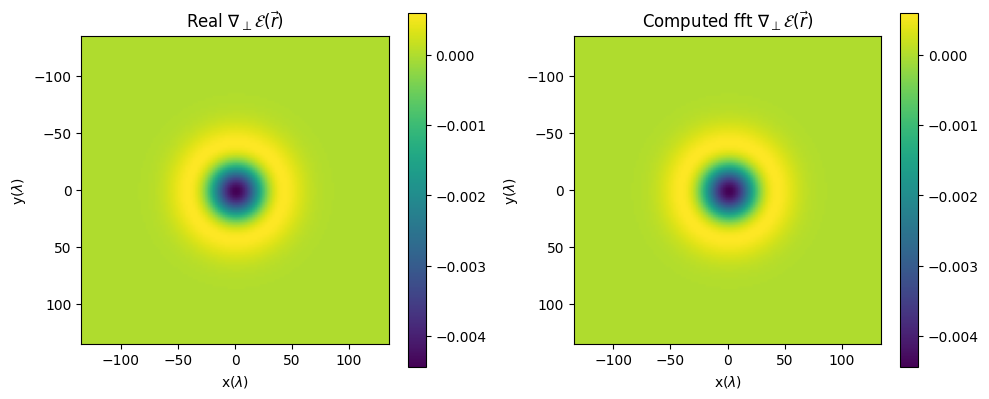

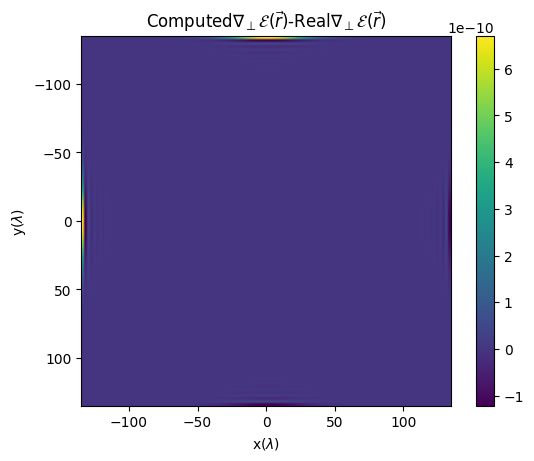

In [7]:
rp = torch.sqrt(X**2 + Y**2)
kp = 2 * torch.pi * torch.sqrt(Fx**2 + Fy**2)
a = 30 * scale_sensor  # Multiply by the scale sensor for keeping size only depending on the writen constant
Ui = torch.exp(-(rp/a)**2)
real_Uo = 4 * ((rp)**2 - a**2) * torch.exp(-(rp/a)**2) / a**4
FT_Uo = iFT(-kp**2 * FT(Ui)).real

L = torch.abs(real_Uo - FT_Uo).sum()

fig, sub = plt.subplots(1,2, figsize=(10,20))

rep1 = sub[0].imshow(real_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep1, ax=sub[0], shrink=0.18)
sub[0].set_title("Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

rep2 = sub[1].imshow(FT_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep2, ax=sub[1], shrink=0.18)
sub[1].set_title("Computed fft $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

for i in range(2):
    sub[i].set_xlabel("x($\\lambda$)")
    sub[i].set_ylabel("y($\\lambda$)")

plt.tight_layout()
print(float(L))

plt.figure()
plt.title("Computed$\\nabla_\\bot \\mathcal{E}(\\vec{r})$-Real$\\nabla_\\bot \\mathcal{E}(\\vec{r})$")
plt.imshow((FT_Uo-real_Uo).detach().cpu(), extent=extent_r)
plt.xlabel("x($\\lambda$)")
plt.ylabel("y($\\lambda$)")
plt.colorbar()
plt.show()

### 2) Implementation of the laplacian with the medium and the first derivative of z

For this section, the equation to treat will be:

$$
\partial_z\mathcal{E}(\vec{r}) = i \left[\nabla^2_\bot\mathcal{E}(\vec{r}) - V(\vec{r})\mathcal{E}(\vec{r})\right]
$$

With $V(\vec{r}) = 4 r_\bot^2$ (Formula for index of refration of a GRIN lens [here](https://www.sciencedirect.com/science/article/pii/S0030402606001288?ref=pdf_download&fr=RR-2&rr=9807669f7b879709)). For this equation, a similar approach will be followed, imposing $\mathcal{E}(x,y,0) = e^{-r_\bot^2}$. Therefore, the analytical solution of this differential equation is:

$$
\mathcal{E}(x,y,z) = e^{-r_\bot^2}e^{-4iz}
$$

While the solution using the method described in [this article](https://essay.utwente.nl/79808/) is:

$$
\mathcal{E}(x,y,z) = \mathcal{E}(x,y,0) e^{iz\left[ \nabla^2_\bot - V(\vec{r}) \right]}
$$

Whose exponential term can be approximated as $e^{iz\left[ \nabla^2_\bot - V(\vec{r}) \right]} \approx e^{\frac{iz}{2}\nabla^2_\bot} e^{-izV(\vec{r})} e^{\frac{iz}{2}\nabla^2_\bot}$ (using [Baker–Campbell–Hausdorff formula](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula) and [Strang Splitting](https://en.wikipedia.org/wiki/Strang_splitting)) and applying the fourier transform, the solution is:

$$
\mathcal{E}(x,y,z) = \mathcal{F}_\bot^{-1}\left\{e^{\frac{iz}{2}k^2_\bot}\mathcal{F}_\bot\left\{ e^{-izV(\vec{r})} \mathcal{F}_\bot^{-1}\left\{e^{\frac{iz}{2}k^2_\bot}\mathcal{F}_\bot\left\{ \mathcal{E}(x,y,0) \right\}\right\}\right\}\right\}
$$

Under these considerations, we will make the calculation of the field in both ways and compare them with the error function:

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3
from IPython.display import display, Image
import io

def show_dual_z_scan_gif(volume1: torch.Tensor,
                         volume2: torch.Tensor,
                         step: int = 1,
                         cmap: str = 'gray',
                         duration: float = 0.1,
                         pix_size: float = 1e-6,
                         tit_1: str = "Volume 1",
                         tit_2:str = "Volume 2"):
    """
    Displays a loop showing all the slices of two volumetric objects side-by-side.

    Args:
        volume1 (torch.Tensor): First volume, shape (D, H, W)
        volume2 (torch.Tensor): Second volume, shape (D, H, W)
        cmap (str, optional): Matplotlib colormap. Defaults to 'gray'.
        duration (float, optional): Frame duration in seconds. Defaults to 0.1.
        pix_size (float, optional): Pixel size in meters. Defaults to 1e-6.
    """

    # Move tensors to CPU and convert to NumPy
    volume1 = volume1.cpu().numpy()
    volume2 = volume2.cpu().numpy()

    assert volume1.shape == volume2.shape, "Volumes must have the same shape"

    D = volume1.shape[0]
    frames = []

    # Shared colormap range
    vmin = min(volume1.min(), volume2.min())
    vmax = max(volume1.max(), volume2.max())

    for z in range(0,D,step):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=80)

        for i, (ax, vol, title) in enumerate(zip(
            axs, [volume1, volume2], [tit_1, tit_2]
        )):
            im = ax.imshow(vol[z], cmap=cmap, vmin=vmin, vmax=vmax)
            ax.axis('off')
            ax.set_title(title, fontsize=10)

            # Add shared colorbar to each subplot
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

            if i == 0:
                # Add Z label only on the first image
                z_pos = (z - D / 2) * pix_size
                label = f"Z = {z_pos:.2f} $\\lambda$"
                ax.text(0.05, 0.95, label, transform=ax.transAxes,
                        fontsize=10, color='white', ha='left', va='top',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v3.imread(buf))
        buf.close()

    # Create looping GIF
    gif_bytes = io.BytesIO()
    imageio.mimsave(gif_bytes, frames, format='gif', duration=duration, loop=0)
    gif_bytes.seek(0)

    display(Image(data=gif_bytes.read(), format='gif'))

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3
from IPython.display import display, Image
import io

def show_dual_z_scan_gif(volume1: torch.Tensor,
                         volume2: torch.Tensor,
                         step: int = 1,
                         cmap: str = 'gray',
                         duration: float = 0.1,
                         pix_size: float = 1e-6,
                         tit_1: str = "Volume 1",
                         tit_2: str = "Volume 2",
                         tit_diff: str = "Difference"):
    """
    Displays a loop showing all the slices of two volumetric objects side-by-side
    and their difference.

    Args:
        volume1 (torch.Tensor): First volume, shape (D, H, W)
        volume2 (torch.Tensor): Second volume, shape (D, H, W)
        step (int, optional): Step size along z. Defaults to 1.
        cmap (str, optional): Matplotlib colormap. Defaults to 'gray'.
        duration (float, optional): Frame duration in seconds. Defaults to 0.1.
        pix_size (float, optional): Pixel size in meters. Defaults to 1e-6.
    """

    # Move tensors to CPU and convert to NumPy
    volume1 = volume1.cpu().numpy()
    volume2 = volume2.cpu().numpy()

    assert volume1.shape == volume2.shape, "Volumes must have the same shape"

    D = volume1.shape[0]
    frames = []

    # Shared colormap ranges
    vmin = min(volume1.min(), volume2.min())
    vmax = max(volume1.max(), volume2.max())

    # Symmetric range for the difference
    diff_vmin = -(np.abs(volume1 - volume2).max())
    diff_vmax = -diff_vmin

    for z in range(0, D, step):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=80)

        # Volumes to plot
        vols = [volume1, volume2, volume1 - volume2]
        titles = [tit_1, tit_2, tit_diff]
        vmins = [vmin, vmin, diff_vmin]
        vmaxs = [vmax, vmax, diff_vmax]

        for i, (ax, vol, title, vmin_, vmax_) in enumerate(zip(
            axs, vols, titles, vmins, vmaxs
        )):
            im = ax.imshow(vol[z], cmap=cmap, vmin=vmin_, vmax=vmax_)
            ax.axis('off')
            ax.set_title(title, fontsize=10)

            # Add colorbar
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

            if i == 0:
                # Add Z label only on the first image
                z_pos = (z - D / 2) * pix_size
                label = f"Z = {z_pos:.2f} $\\lambda$"
                ax.text(0.05, 0.95, label, transform=ax.transAxes,
                        fontsize=10, color='white', ha='left', va='top',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v3.imread(buf))
        buf.close()

    # Create looping GIF
    gif_bytes = io.BytesIO()
    imageio.mimsave(gif_bytes, frames, format='gif', duration=duration, loop=0)
    gif_bytes.seek(0)

    display(Image(data=gif_bytes.read(), format='gif'))


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3
from IPython.display import display, Image
import io
import h5py

def show_dual_z_scan_gif_from_hdf5(h5_filename: str,
                                   step: int = 1,
                                   cmap: str = 'gray',
                                   duration: float = 0.1,
                                   pix_size: float = 1e-6,
                                   tit_1: str = "Volume 1",
                                   tit_2: str = "Volume 2",
                                   tit_diff: str = "Diff (Vol2 - Vol1)"):
    """
    Muestra los slices de dos volúmenes guardados en un archivo HDF5 y su diferencia.
    
    Args:
        h5_filename (str): Ruta al archivo HDF5 generado por naive_gpu_propagate_hdf5
        step (int, optional): Paso entre slices. Default=1
        cmap (str, optional): Colormap de Matplotlib. Default='gray'
        duration (float, optional): Duración de cada frame en segundos. Default=0.1
        pix_size (float, optional): Tamaño de pixel en metros. Default=1e-6
        tit_1 (str, optional): Título para volumen 1
        tit_2 (str, optional): Título para volumen 2
        tit_diff (str, optional): Título para la diferencia
    """

    with h5py.File(h5_filename, "r") as f:
        volume1 = f["frames1"][:]  # shape (D,H,W)
        volume2 = f["frames2"][:]
    
    assert volume1.shape == volume2.shape, "Los volúmenes deben tener la misma forma"

    diff = volume2 - volume1
    D = volume1.shape[0]
    frames = []

    # Rango compartido para intensidades
    vmin = min(volume1.min(), volume2.min(), diff.min())
    vmax = max(volume1.max(), volume2.max(), diff.max())

    for z in range(0, D, step):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=80)

        for i, (ax, vol, title) in enumerate(zip(
            axs, [volume1, volume2, diff], [tit_1, tit_2, tit_diff]
        )):
            im = ax.imshow(vol[z], cmap=cmap, vmin=vmin, vmax=vmax)
            ax.axis('off')
            ax.set_title(title, fontsize=10)

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

            if i == 0:
                # Z en unidades de longitud de onda
                z_pos = (z - D / 2) * pix_size
                label = f"Z = {z_pos:.2e} m"
                ax.text(0.05, 0.95, label, transform=ax.transAxes,
                        fontsize=10, color='white', ha='left', va='top',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v3.imread(buf))
        buf.close()

    # Guardar GIF en memoria
    gif_bytes = io.BytesIO()
    imageio.mimsave(gif_bytes, frames, format='gif', duration=duration, loop=0)
    gif_bytes.seek(0)

    display(Image(data=gif_bytes.read(), format='gif'))


In [11]:
import torch
a = torch.zeros([4,4,3])
print(list(a.shape))

[4, 4, 3]


Execution time of the core process is: 9.65889950003475s


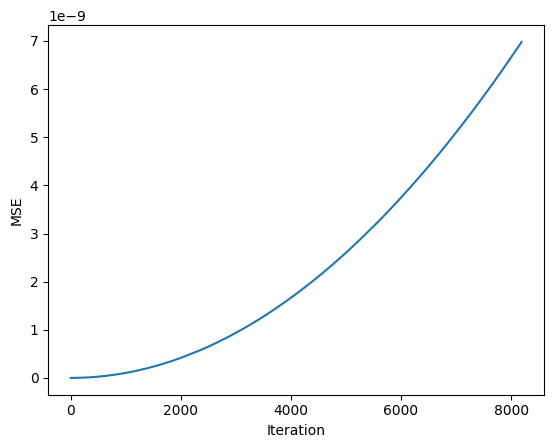

MSE = 5.515928945646585e-13


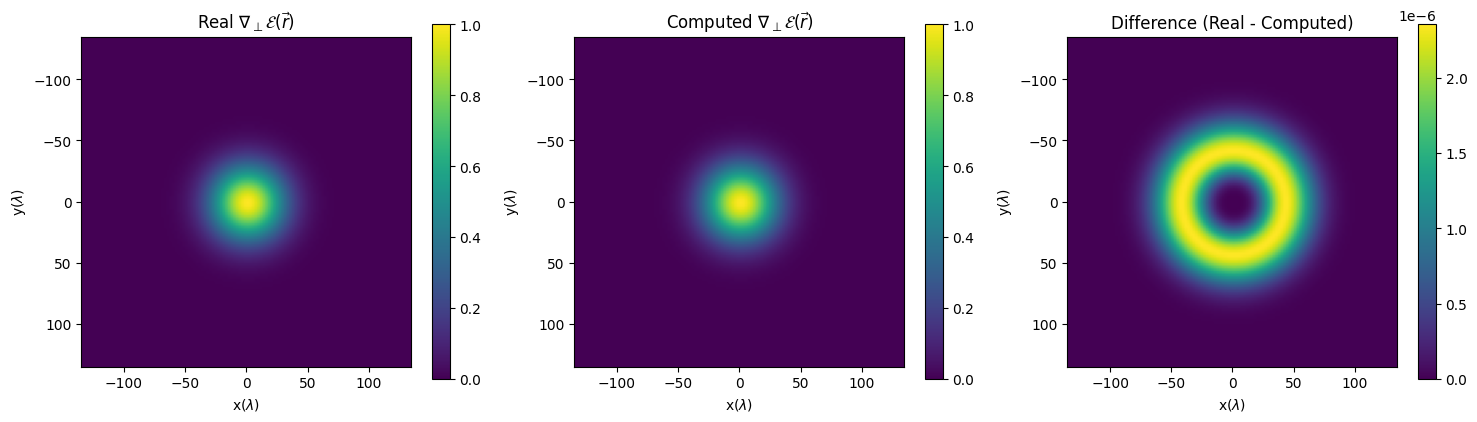

In [ ]:
import time
import tqdm

from matplotlib import axes
λ = 1
dz = 1e-10#(pix_size * λ)**2 / λ # I need 0.01 * λ -> Otherwise error grows (unstable)
Nz = 8191
Vr = 4*rp**2

prop_Uo = Ui
frames1 = []
frames2 = []
start = time.perf_counter()
x_steps = torch.tensor(np.arange(Nz)[:,None,None], device=device)

for i in range(Nz):
    prop_Uo = iFT(torch.exp(-1j * dz * kp**2 / 2) * FT(prop_Uo))
    prop_Uo *= torch.exp(-1j * dz * Vr)
    prop_Uo = iFT(torch.exp(-1j * dz * kp**2 / 2) * FT(prop_Uo))

    img2 = prop_Uo.detach().cpu().numpy()
    
    frames2.append(img2)

frames1 = (Ui[None] * torch.exp(-4j * dz * x_steps)).detach().cpu()
frames2 = torch.tensor(np.array(frames2))

end = time.perf_counter()
print(f"Execution time of the core process is: {end-start}s")
#show_dual_z_scan_gif(frames1, frames2, cmap= 'viridis', duration = 0.1, pix_size = dz,
#                     tit_1="Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$", 
#                     tit_2="Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

#frames_loss = ((frames1 - frames2)**2).sum(dim=(1,2)) / prop_Uo.numel()
frames_loss = (frames1.abs()**2 - frames2[0][None].abs()**2).sum(dim=(1,2)) / np.prod(pix_size)

plt.figure()
plt.plot(frames_loss)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

real_Uo = frames1[-1].to(device=device).real
prop_Uo = prop_Uo.real

L = ((real_Uo - prop_Uo)**2).sum() / prop_Uo.numel()

fig, sub = plt.subplots(1, 3, figsize=(15, 20))

# Real
rep1 = sub[0].imshow(real_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep1, ax=sub[0], shrink=0.18)
sub[0].set_title("Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

# Computed
rep2 = sub[1].imshow(prop_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep2, ax=sub[1], shrink=0.18)
sub[1].set_title("Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

# Difference
diff = real_Uo.detach().cpu() - prop_Uo.detach().cpu()
rep3 = sub[2].imshow(diff, extent=extent_r)
plt.colorbar(rep3, ax=sub[2], shrink=0.18)
sub[2].set_title("Difference (Real - Computed)")

# Labels
for i in range(3):
    sub[i].set_xlabel("x($\\lambda$)")
    sub[i].set_ylabel("y($\\lambda$)")

plt.tight_layout()
print(f"MSE = {L}")

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import time

from IPython import start_ipython
from numpy import real
sys.path.append("..")  # adjust as needed

from fgrinmet.splitm import propagate_paraxial


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SyntaxError: invalid syntax. Perhaps you forgot a comma? (propagation.py, line 16)

We use the module:

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

from IPython import start_ipython
from numpy import real
sys.path.append("..")  # adjust as needed

from fgrinmet.splitm.propagation import naive_gpu_propagate_hdf5

dz = 0.01 / λ
Nz = 100
Vr = (4*rp**2).repeat(Nz,1,1)
# 1. Generar propagación y guardar en archivo
start= time.perf_counter()
naive_gpu_propagate_hdf5(Ui, dz, Nz, kp, Vr, filename="naive_frames.h5", batch_size=16)
end = time.perf_counter()
print(f"Execution time of the core process is: {end-start}s")

# 2. Mostrar desde archivo
show_dual_z_scan_gif_from_hdf5("naive_frames.h5", cmap='viridis', duration=0.1, pix_size=dz,
    tit_1="Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$",
    tit_2="Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SyntaxError: invalid syntax. Perhaps you forgot a comma? (propagation.py, line 16)

Write from 0 the algorithm:

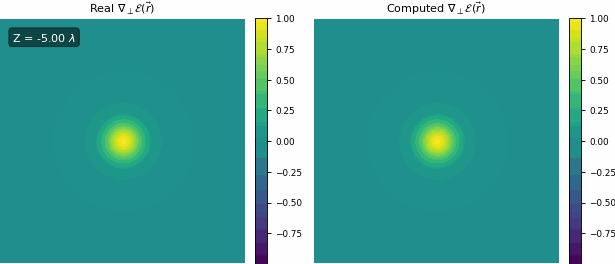

10.105829465941273


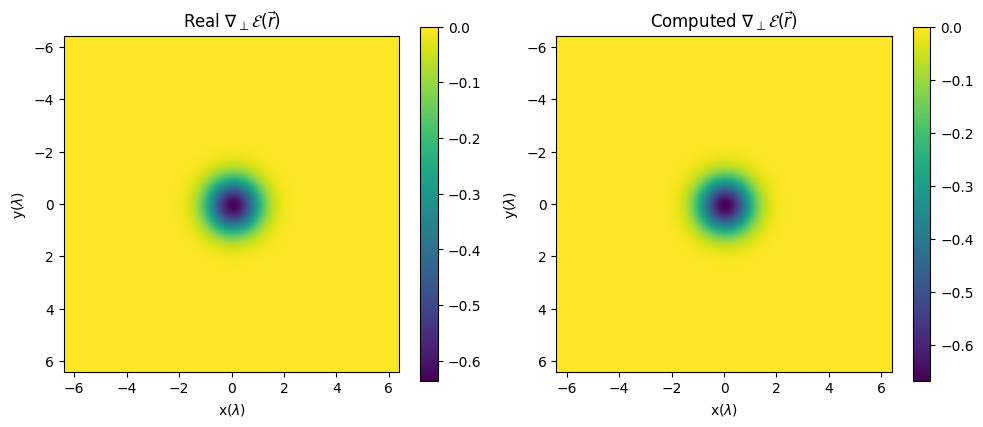

In [ ]:
dz = 0.01 / λ
Nz = 1000
Vr = 4*rp**2

prop_Uo = Ui
frames1 = []
frames2 = []
for i in range(Nz):
    real_Uo = Ui * torch.exp(torch.tensor(-4j * dz * i, device=device))

    prop_Uo = iFT(torch.exp(-1j * dz * kp**2 / 2) * FT(prop_Uo))
    prop_Uo *= torch.exp(-1j * dz * Vr)
    prop_Uo = iFT(torch.exp(-1j * dz * kp**2 / 2) * FT(prop_Uo))

    img1 = real_Uo.real.detach().cpu().numpy()
    img2 = prop_Uo.real.detach().cpu().numpy()
    
    frames1.append(img1)
    frames2.append(img2)

frames1 = torch.tensor(np.array(frames1))
frames2 = torch.tensor(np.array(frames2))
    
show_dual_z_scan_gif(frames1, frames2, cmap= 'viridis', duration = 0.1, pix_size = dz,
                     tit_1="Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$", 
                     tit_2="Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

real_Uo = real_Uo.real
prop_Uo = prop_Uo.real


L = torch.abs(real_Uo - prop_Uo).sum()

fig, sub = plt.subplots(1,2, figsize=(10,20))

rep1 = sub[0].imshow(real_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep1, ax=sub[0], shrink=0.18)
sub[0].set_title("Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

rep2 = sub[1].imshow(prop_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep2, ax=sub[1], shrink=0.18)
sub[1].set_title("Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

for i in range(2):
    sub[i].set_xlabel("x($\\lambda$)")
    sub[i].set_ylabel("y($\\lambda$)")

plt.tight_layout()
print(float(L))


I can try to use a numerical method to solve the ODE(Euler, Adams or R-K) considering the following differential equation:

$$
\partial_z \mathcal{F}_\bot\left\{ \mathcal{E}(\vec{r}) \right\} = -i \left[ k_\bot^2 \mathcal{F}_\bot\left\{ \mathcal{E}(\vec{r}) \right\} + \mathcal{F}_\bot\left\{ V(\vec{r})\mathcal{E}(\vec{r}) \right\}\right]
$$

Which we can consider as:

$$
\frac{dy}{dz} = f(z,y)
$$

With $y = \mathcal{F}_\bot\left\{ \mathcal{E}(\vec{r}) \right\}$ and $f(z,y)=-i \left[ k_\bot^2 \mathcal{F}_\bot\left\{ \mathcal{E}(\vec{r}) \right\} + \mathcal{F}_\bot\left\{ V(\vec{r})\mathcal{E}(\vec{r}) \right\}\right]$. Therefore, by using Euler's method, the iterative solution considering $z=z_0 + hn$ and $h = z_{n+1} - z_n$ would be:

$$
y_{n+1} = y_{n} + h f_n + \mathcal{O}(h^2)
$$

If the precision is intended to be improved, a method whose error scales with $h^3$ is Adams-Bashforth:

$$
y_{n+1} = y_{n} + \frac{h}{2}\left[3f_n - f_{n-1}\right] + \mathcal{O}(h^3)
$$

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3
from IPython.display import display, Image
import io

def show_dual_z_scan_gif(volume1: torch.Tensor,
                         volume2: torch.Tensor,
                         step: int = 1,
                         cmap: str = 'gray',
                         duration: float = 0.1,
                         pix_size: float = 1e-6,
                         tit_1: str = "Volume 1",
                         tit_2:str = "Volume 2"):
    """
    Displays a loop showing all the slices of two volumetric objects side-by-side.

    Args:
        volume1 (torch.Tensor): First volume, shape (D, H, W)
        volume2 (torch.Tensor): Second volume, shape (D, H, W)
        cmap (str, optional): Matplotlib colormap. Defaults to 'gray'.
        duration (float, optional): Frame duration in seconds. Defaults to 0.1.
        pix_size (float, optional): Pixel size in meters. Defaults to 1e-6.
    """

    # Move tensors to CPU and convert to NumPy
    volume1 = volume1.cpu().numpy()
    volume2 = volume2.cpu().numpy()

    assert volume1.shape == volume2.shape, "Volumes must have the same shape"

    D = volume1.shape[0]
    frames = []

    # Shared colormap range
    #vmin = min(volume1.min(), volume2.min())
    #vmax = max(volume1.max(), volume2.max())

    for z in range(0,D,step):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=80)

        for i, (ax, vol, title) in enumerate(zip(
            axs, [volume1, volume2], [tit_1, tit_2]
        )):
            im = ax.imshow(vol[z], cmap=cmap)#, vmin=vmin, vmax=vmax)
            ax.axis('off')
            ax.set_title(title, fontsize=10)

            # Add shared colorbar to each subplot
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

            if i == 0:
                # Add Z label only on the first image
                z_pos = (z - D / 2) * pix_size
                label = f"Z = {z_pos:.2f} $\\lambda$"
                ax.text(0.05, 0.95, label, transform=ax.transAxes,
                        fontsize=10, color='white', ha='left', va='top',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')#, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v3.imread(buf))
        buf.close()

    # Create looping GIF
    gif_bytes = io.BytesIO()
    imageio.mimsave(gif_bytes, frames, format='gif', duration=duration, loop=0)
    gif_bytes.seek(0)

    display(Image(data=gif_bytes.read(), format='gif'))

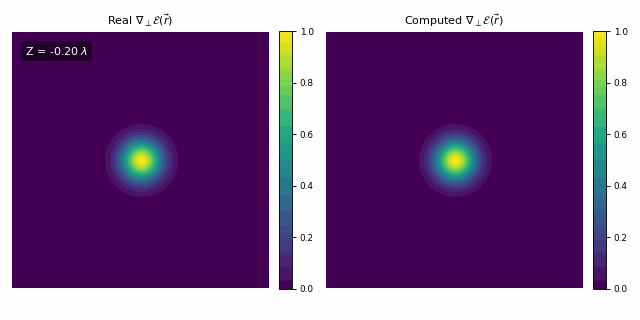

0.12562512072469365


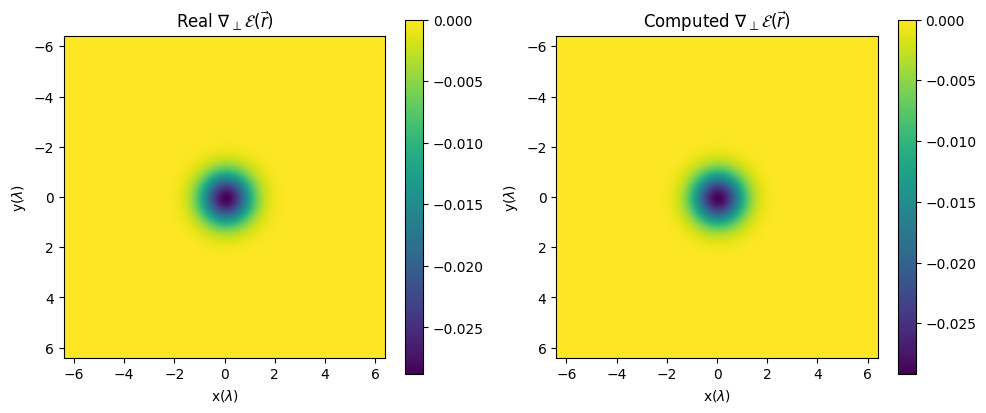

In [ ]:
dz = 0.0001 / λ
Nz = 4000
Vr = 4*rp**2

adams_Uo = Ui
frames1 = [Ui.real.detach().cpu().numpy()]
frames2 = [Ui.real.detach().cpu().numpy()]

y0 = FT(Ui)
f0 = 1j * (-kp**2 * y0 - FT(Vr * iFT(y0)))
f1 = 1j * (-kp**2 * y0 - FT(Vr * iFT(y0)))

# Apply the first Euler
y0 = y0 + dz * f0
adams_Uo = iFT(y0)
f1 = 1j * (-kp**2 * y0 - FT(Vr * adams_Uo))

img1 = real_Uo.real.detach().cpu().numpy()
img2 = adams_Uo.real.detach().cpu().numpy()

frames1.append(img1)
frames2.append(img2)

# Apply Adams h^3
y0 = y0 + (dz/2) * (3 * f1 - f0)
adams_Uo = iFT(y0)
f2 = 1j * (-kp**2 * y0 - FT(Vr * adams_Uo))

for i in range(2, Nz):
    real_Uo = Ui * torch.exp(torch.tensor(-4j * dz * i, device=device))

    y0 = y0 + (dz/12) * (23 * f2 - 16 * f1 + 5 * f0)
    f0 = f1.detach().clone()
    f1 = f2.detach().clone()
    adams_Uo = iFT(y0)
    f2 = 1j * (-kp**2 * y0 - FT(Vr * adams_Uo))
        

    img1 = real_Uo.real.cpu().numpy()
    img2 = adams_Uo.real.cpu().numpy()
    
    frames1.append(img1)
    frames2.append(img2)

frames1 = np.asarray(frames1)
frames2 = np.asarray(frames2)
frames1 = torch.tensor(frames1, device=device)
frames2 = torch.tensor(frames2, device=device)

show_dual_z_scan_gif(frames1, frames2, step=10, cmap= 'viridis', duration = 0.1, pix_size = dz,
                     tit_1="Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$", 
                     tit_2="Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

real_Uo = real_Uo.real
adams_Uo = adams_Uo.real


L = torch.abs(real_Uo - adams_Uo).sum()

fig, sub = plt.subplots(1,2, figsize=(10,20))

rep1 = sub[0].imshow(real_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep1, ax=sub[0], shrink=0.18)
sub[0].set_title("Real $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

rep2 = sub[1].imshow(adams_Uo.detach().cpu(), extent=extent_r)
plt.colorbar(rep2, ax=sub[1], shrink=0.18)
sub[1].set_title("Computed $\\nabla_\\bot \\mathcal{E}(\\vec{r})$")

for i in range(2):
    sub[i].set_xlabel("x($\\lambda$)")
    sub[i].set_ylabel("y($\\lambda$)")

plt.tight_layout()
print(float(L))


It can be seen that for the calculation, a very small step is needed. -> Maybe higher orders?